# CSCE 670 Project: Online Lockstep Behavior Detection
### Team: End of Fraud
### Members: Majid Alfifi, Parisa Kaghazgaran, Xing Zhao

## Introduction and Problem Statement


How can we detect if a politician has purchased fake followers on Twitter or if a product’s reviews on Amazon are not genuine or some businesses have employed people to manipulate thier reviews in Yelp? In this project, we answer these questions by adopting D-cube approach from [1].  



## Related Work

A common method to detect lock-step behavior has been to represent users and items as a matrix where in the simplest case a cell can take on a binary value of 1 or 0 indicating whether there is a relationship between the corresponding user and item or not. The problem can then be transformed to finding dense regions in this matrix [2].

## Approach / Methods

D-cube detects extraordinary dense blocks in the tensor which are correspond to groups of users with lockstep behaviors both in the items they relate to and along the additional dimensions (for example, multiple users reviewing the same products at in the same time duration). Technically speaking, D-cube is an iterative algorithm which removes slices from the tensor untill the remaining block is dense enough. The density can be measured by different functions. In each iteration, the algorithm picks the dimention with largest cardinality and then breaks the tensor into matrices/ slices from selected dimension. For each slice, it calculate the mass which is summation of cell values. Then, removes the slices with mass values lower than average and calculates the density for remaining tensor. The following figure shows the overall approach for the Evaluation.

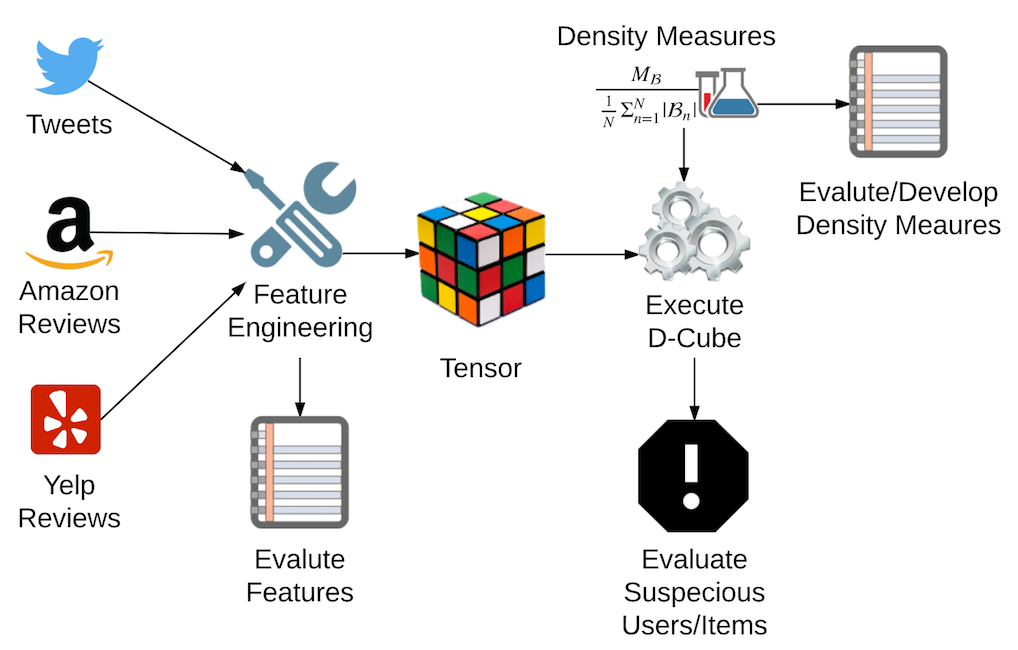

In [106]:
from IPython.core.display import Image  
Image(filename='figure1.png', width = 450, height = 300) 

## References


[1]. K. Shin, B. Hooi, J. Kim, and C. Faloutsos. D-cube: Dense-block detection in terabyte-scale tensors. In Pro- ceedings of the Tenth ACM International Conference on Web Search and Data Mining, pages 681–689. ACM, 2017.

[2]. B. Hooi, H. A. Song, A. Beutel, N. Shah, K. Shin, and C. Faloutsos. Fraudar: Bounding graph fraud in the face of camouflage. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Dis- covery and Data Mining, pages 895–904. ACM, 2016.

## Implementation

In the following, D-cube approach is evaluated on three different dataset-- Twitter, Amazon, Yelp. More importantly, we were able to successfully implement the D-cube on spark. 

## Dense-Block Detection in Terabyte-Scale Tensors (Twitter)

In [13]:
# Hide code
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# general imports
sc.setLogLevel("INFO")

from IPython.display import Image, HTML
import pickle

from pyspark.sql.types import *

import plotly
from plotly import tools
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import math
import numpy as np
import pandas as pd

import pyspark.sql.functions as F

pd.set_option('display.max_colwidth', 600)

In [3]:
# read users that were suspended by Twitter
from pyspark.sql.types import StructType, StructField, StringType, LongType

path = '/user/aralytics-compliance/scraped/20161226'

schema = StructType([StructField('user_id',LongType(),True),StructField('status',StringType(),True)])

user_status = spark.read.csv(
    path=path,
    encoding='UTF-8',
    sep='\t',
    schema=schema,
    quote="",
    mode='DROPMALFORMED',
    ignoreLeadingWhiteSpace=True)

users_suspended = user_status.filter(F.instr(user_status.status,'Account Suspended')>0).select('user_id').cache()

### Twitter datasets
0. User vs. URLs
0. User vs. Mentions
0. User vs. Hashtags

In [2]:
# tweets = spark.read.parquet('/user/aralytics-parquet/2015/01')

# tweets_count   = tweets.count()
# users_count    = tweets.select('user.id').distinct().count()
# hashtags_count = tweets.select(F.explode('entities.hashtags.text')).distinct().count()
# urls_count     = tweets.select(F.explode('entities.urls.expanded_url')).distinct().count()

### Run D-Cube on Twitter Users & Hashtags, URLs, and Mentions

**Input**: Arabic Tweets generated in January 2015

| Set    | Size          |
|--------|---------------|
| Tweets | 1,231,415,376 |
| users (unique)  | 8,242,091   |
| Hashtags (unique)| 1,971,871 |
| URLs (unique)| 27,649,967   |
| Mentions (unique)| 4,435,200   |


**Output**: 
0. Potential fraudulent users and *hashtags* they participated in.
0. Potential fraudulent users and *urls* they shared.a
0. Potential fraudulent users and other users they *mentioned*.

In [4]:
# generate datasets from raw tweets
run=False 
if run: # long running operation
    
    tweets = spark.read.parquet('/user/aralytics-parquet/2015/01')

    hashtags = tweets.select(F.col('user.id').alias('user_id'),
                             'created_at',
                             F.explode('entities.hashtags.text').alias('hashtag'))

    urls     = tweets.select(F.col('user.id').alias('user_id'),
                             'created_at',
                             F.explode('entities.urls.expanded_url').alias('url'))
    
    mentions = tweets.select(F.col('user.id').alias('user_id'),
                             'created_at',
                             F.explode('entities.user_mentions.id').alias('mention_id'))

    hashtags.write.parquet('dcube/data-raw/user-hashtags-2015-01')
    urls.write.parquet('dcube/data-raw/user-urls-2015-01')
    mentions.write.parquet('dcube/data-raw/user-mentions-2015-01')

In [5]:
# index hashtags
run=False 

if run: # long running operation
    hashtags = spark.read.parquet('dcube/data-raw/user-hashtags-2015-01')
    hashtags_indexed = hashtags.select('hashtag')\
                           .distinct()\
                           .sort('hashtag')\
                           .rdd\
                           .map(lambda x: x[0])\
                           .zipWithIndex()\
                           .toDF(['hashtag','hashtag_index']).cache()

    user_ids_indexed = hashtags.select('user_id')\
                           .distinct()\
                           .sort('user_id')\
                           .rdd\
                           .map(lambda x: x[0])\
                           .zipWithIndex()\
                           .toDF(['user_id','user_id_index'])

    hashtags = hashtags.join(hashtags_indexed,['hashtag'])\
                       .join(user_ids_indexed,['user_id'])\
                       .withColumn('timestamp', 24*(F.dayofmonth('created_at')-1) + F.hour('created_at'))
    
    hashtags.write.parquet('dcube/data/hashtags-indexed')

hashtags = spark.read.parquet('dcube/data/hashtags-indexed')

# show a sample
print 'Sample of User Hashtags Relation:'                        
hashtags.filter(F.instr(F.col('hashtag'),'m')>0).show(10,False)

Sample of User Hashtags Relation:
+--------+---------------+---------------------+-------------+-------------+---------+
|user_id |hashtag        |created_at           |hashtag_index|user_id_index|timestamp|
+--------+---------------+---------------------+-------------+-------------+---------+
|47613   |Zamalek104     |2015-01-06 08:07:52.0|131538       |16           |128      |
|14256152|fromAtoB       |2015-01-26 21:28:29.0|164981       |1120         |621      |
|14256152|FromAtoB       |2015-01-16 15:30:45.0|44208        |1120         |375      |
|14256152|FromAtoB       |2015-01-22 08:57:27.0|44208        |1120         |512      |
|14256152|FromAtoB       |2015-01-21 07:46:46.0|44208        |1120         |487      |
|19118845|kadim          |2015-01-10 20:20:01.0|178471       |4109         |236      |
|19118845|3mr            |2015-01-17 22:38:27.0|4923         |4109         |406      |
|19118845|I_love_Muhammad|2015-01-15 22:25:57.0|55674        |4109         |358      |
|19118845

In [6]:
# index URLs
run=False 

if run: # long running operation
    urls = spark.read.parquet('dcube/data-raw/user-urls-2015-01')
    urls_indexed = urls.select('url')\
                   .distinct()\
                   .sort('url')\
                   .rdd\
                   .map(lambda x: x[0])\
                   .zipWithIndex()\
                   .toDF(['url','url_index'])

    user_ids_indexed = urls.select('user_id')\
                    .distinct()\
                    .sort('user_id')\
                    .rdd\
                    .map(lambda x: x[0])\
                    .zipWithIndex()\
                    .toDF(['user_id','user_id_index'])

    urls = urls.join(urls_indexed,['url'])\
               .join(user_ids_indexed,['user_id'])\
               .withColumn('timestamp', 24*(F.dayofmonth('created_at')-1) + F.hour('created_at'))
    
    urls.write.parquet('dcube/data/urls-indexed')

urls = spark.read.parquet('dcube/data/urls-indexed')

# show a sample
print 'Sample of User-URLs Relation:'                        
urls.filter(F.length('url')<40).show(10,False)

Sample of User-URLs Relation:
+-------+-------------------------------------+---------------------+---------+-------------+---------+
|user_id|url                                  |created_at           |url_index|user_id_index|timestamp|
+-------+-------------------------------------+---------------------+---------+-------------+---------+
|5396682|http://youtu.be/i0GW0Vnr9Yc          |2015-01-27 15:54:04.0|26547235 |194          |639      |
|5396682|http://www.raseef22.com/life/        |2015-01-12 10:44:24.0|23269965 |194          |274      |
|5396682|http://www.raseef22.com/life/        |2015-01-12 10:43:08.0|23269965 |194          |274      |
|5396682|http://www.alqabas.com.kw/node/925572|2015-01-12 10:47:32.0|22093386 |194          |274      |
|5396682|http://raseef22.com/technology/      |2015-01-24 17:33:03.0|19604726 |194          |569      |
|5396682|http://www.alqabas.com.kw/node/928069|2015-01-15 10:44:27.0|22094137 |194          |346      |
|5396682|http://www.alqabas.com.kw

In [7]:
# index mentions
run=False 

if run: # long running operation
    mentions = spark.read.parquet('dcube/data-raw/user-mentions-2015-01')
    user_ids_indexed = mentions.select('user_id')\
                           .distinct()\
                           .sort('user_id')\
                           .rdd\
                           .map(lambda x: x[0])\
                           .zipWithIndex()\
                           .toDF(['user_id','user_id_index'])

    mention_ids_indexed = mentions.select('mention_id')\
                           .distinct()\
                           .sort('mention_id')\
                           .rdd\
                           .map(lambda x: x[0])\
                           .zipWithIndex()\
                           .toDF(['mention_id','mention_id_index'])

    mentions = mentions.join(user_ids_indexed,['user_id'])\
               .join(mention_ids_indexed,['mention_id'])\
               .withColumn('timestamp', 24*(F.dayofmonth('created_at')-1) + F.hour('created_at'))
    
    mentions.write.parquet('dcube/data/mentions-indexed')

mentions = spark.read.parquet('dcube/data/mentions-indexed')

#show a sample
print 'Sample of User-Mentions Relation:'                        
mentions.show(10,False)

Sample of User-Mentions Relation:
+----------+----------+---------------------+-------------+----------------+---------+
|mention_id|user_id   |created_at           |user_id_index|mention_id_index|timestamp|
+----------+----------+---------------------+-------------+----------------+---------+
|11511     |2897119887|2015-01-01 16:27:47.0|4829958      |159             |16       |
|11511     |2642740862|2015-01-07 18:54:30.0|4048444      |159             |162      |
|11511     |2837225879|2015-01-07 17:29:36.0|4548729      |159             |161      |
|11511     |333268176 |2015-01-07 17:17:53.0|446871       |159             |161      |
|11511     |380884382 |2015-01-12 23:00:04.0|598313       |159             |287      |
|11511     |380884382 |2015-01-11 11:07:27.0|598313       |159             |251      |
|11511     |380884382 |2015-01-12 14:00:13.0|598313       |159             |278      |
|621543    |583926942 |2015-01-26 00:41:44.0|1294919      |388             |600      |
|764537  

In [8]:
# save relations in a tensor format ready for D-Cube
run =False
if run:
    hashtags.groupby('user_id_index','hashtag_index','timestamp').count().write.csv('dcube/data/hashtags-tensor')
    urls.groupby('user_id_index','hashtag_index','timestamp').count().write.csv('dcube/data/urls-tensor')
    mentions.groupby('user_id_index','hashtag_index','timestamp').count().write.csv('dcube/data/mentions-tensor')

## Analysis 1: User-Hashtags

In [14]:
# Read d-cube output

schema = StructType([StructField(col, LongType(), True) for col in ['user_id_index','hashtag_index','timestamp','count']])

dcube_output_hashtags = spark.read.csv(
    path='dcube/output/hashtags-output/block_1.tuples',
    sep=',',
    schema=schema)\
    .join(hashtags.select('hashtag', 'hashtag_index').distinct(), ['hashtag_index'])\
    .join(hashtags.select('user_id', 'user_id_index').distinct(), ['user_id_index'])                

print 'Sample of Tuples found by D-Cube'
dcube_output_hashtags.filter(F.instr(F.col('hashtag'),'a')>0).show()

Sample of Tuples found by D-Cube
+-------------+-------------+---------+-----+------------+--------+
|user_id_index|hashtag_index|timestamp|count|     hashtag| user_id|
+-------------+-------------+---------+-----+------------+--------+
|         7225|        28503|      173|    1|CharlieHebdo|29008271|
|         7225|        28503|      388|    1|CharlieHebdo|29008271|
|         7225|        97522|      495|    1|       Saudi|29008271|
|         7225|        97522|      644|    1|       Saudi|29008271|
|         7225|        97522|      663|    1|       Saudi|29008271|
|        12044|        89731|      141|    1|       Quran|42171470|
|        12044|        89731|        7|    1|       Quran|42171470|
|        12044|        89731|      182|    1|       Quran|42171470|
|        12044|        89731|      470|    1|       Quran|42171470|
|        12044|        89731|       31|    1|       Quran|42171470|
|        12044|        89731|       45|    1|       Quran|42171470|
|        12044|

In [120]:
# Analyze output of D-Cube on Users-Hashtags
run = False
if run:
    hashtags_dcube_users_count = dcube_output_hashtags.select('user_id').distinct().count()
    hashtags_dcube_hashtags_count =dcube_output_hashtags.select('hashtag').distinct().count()
    hashtags_dcube_users_suspended = dcube_output_hashtags.select('user_id').distinct().join(users_suspended, 'user_id').count()
    hashtags_suspended_by_twitter = hashtags.select('user_id').distinct().join(users_suspended,'user_id').count()
    hashtags_tuples_count = hashtags.count()
    hashtags_users_count = hashtags.select('user_id').distinct().count()
    hashtags_hashtags_count = hashtags.select('hashtag').distinct().count()
    hashtags_dcube_tuples_count = dcube_output_hashtags.count()

print 'D-Cube Input:'
print "  {:,}".format(hashtags_tuples_count).rjust(13), ' number of tubles.\n'
print "  {:,}".format(hashtags_users_count).rjust(13), ' users.'
print "  {:,}".format(hashtags_suspended_by_twitter).rjust(13), '  of which were suspended by Twitter.\n'
print "  {:,}".format(hashtags_hashtags_count).rjust(13), ' hashtags.'

print '\nD-Cube Output:'
print "  {:,}".format(hashtags_dcube_tuples_count).rjust(13), ' number of tubles.\n'
print "  {:,}".format(hashtags_dcube_users_count).rjust(13), ' users.'
print "  {:,}".format(hashtags_dcube_users_suspended).rjust(13), '  of which were later suspended by Twitter.\n'
print "  {:,}".format(hashtags_dcube_hashtags_count).rjust(13), ' hashtags.'

D-Cube Input:
  733,382,389  number of tubles.

    4,619,037  users.
      622,887   of which were suspended by Twitter.

    1,971,871  hashtags.

D-Cube Output:
  287,205,317  number of tubles.

      433,226  users.
      198,613   of which were later suspended by Twitter.

        2,447  hashtags.


In [55]:
circle1_text = 'Suspended by Twitter '+"{:,}".format(suspended_by_twitter).rjust(9)
circle2_text = "{:,}".format(dcube_users_suspended).rjust(9)
circle3_text = 'Found by D-Cube '+ "{:,}".format(dcube_users_count).rjust(9)
trace0 = go.Scatter(
    x=[1, 1.75, 2.5],
    y=[1, 1, 1],
    text=[circle1_text, circle2_text, circle3_text],
    mode='text',
    textfont=dict(
        color='black',
        size=18,
        family='Arail',
    )
)

data = [trace0]

layout = {
    'xaxis': {
        'showticklabels': False,
        'autotick': False,
        'showgrid': False,
        'zeroline': False,
    },
    'yaxis': {
        'showticklabels': False,
        'autotick': False,
        'showgrid': False,
        'zeroline': False,
    },
    'shapes': [
        {
            'opacity': 0.3,
            'xref': 'x',
            'yref': 'y',
            'fillcolor': 'blue',
            'x0': 0,
            'y0': 0,
            'x1': 2.5,
            'y1': 2,
            'type': 'circle',
            'line': {
                'color': 'blue',
            },
        },
        {
            'opacity': 0.3,
            'xref': 'x',
            'yref': 'y',
            'fillcolor': 'gray',
            'x0': 1.5,
            'y0': 0,
            'x1': 3,
            'y1': 2,
            'type': 'circle',
            'line': {
                'color': 'gray',
            },
        }
    ],
    'margin': {
        'l': 20,
        'r': 20,
        'b': 100
    },
    'height': 600,
    'width': 800,
}

fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig, show_link=False)

## Next User-URLS ...

In [57]:
# Read d-cube output

schema = StructType([StructField(col, LongType(), True) for col in ['user_id_index','url_index','timestamp','count']])

dcube_output_urls = spark.read.csv(
    path='dcube/output/urls-output/block_1.tuples',
    sep=',',
    schema=schema)\
    .join(urls.select('url', 'url_index').distinct(), ['url_index'])\
    .join(urls.select('user_id', 'user_id_index').distinct(), ['user_id_index'])                

print 'Sample of Tuples found by D-Cube'

dcube_output_urls.filter(F.length('url')<40).show(10,False)

Sample of Tuples found by D-Cube
+-------------+---------+---------+-----+--------------------+--------+
|user_id_index|url_index|timestamp|count|url                 |user_id |
+-------------+---------+---------+-----+--------------------+--------+
|17979        |15777481 |132      |2    |http://goo.gl/Ux7VfM|52808813|
|17979        |15777481 |141      |1    |http://goo.gl/Ux7VfM|52808813|
|17979        |15777481 |140      |4    |http://goo.gl/Ux7VfM|52808813|
|17979        |15777481 |119      |2    |http://goo.gl/Ux7VfM|52808813|
|17979        |15777481 |118      |1    |http://goo.gl/Ux7VfM|52808813|
|17979        |16177512 |165      |19   |http://goo.gl/lAI6I5|52808813|
|17979        |16177512 |107      |16   |http://goo.gl/lAI6I5|52808813|
|17979        |16177512 |167      |19   |http://goo.gl/lAI6I5|52808813|
|17979        |16177512 |90       |16   |http://goo.gl/lAI6I5|52808813|
|17979        |16177512 |111      |16   |http://goo.gl/lAI6I5|52808813|
+-------------+---------+------

In [119]:
# Analyze output of D-Cube on Users-URLS

run = False
if run:
    urls_dcube_users_count = dcube_output_urls.select('user_id').distinct().count()
    urls_dcube_urls_count =dcube_output_urls.select('url').distinct().count()
    urls_dcube_users_suspended = dcube_output_urls.select('user_id').distinct().join(users_suspended, 'user_id').count()
    urls_suspended_by_twitter = urls.select('user_id').distinct().join(users_suspended,'user_id').count()
    urls_tuples_count = urls.count()
    urls_users_count = urls.select('user_id').distinct().count()
    urls_urls_count = urls.select('url').distinct().count()
    urls_dcube_tuples_count = dcube_output_urls.count()

print 'D-Cube Input:'
print "  {:,}".format(urls_tuples_count).rjust(13), ' number of tubles.\n'
print "  {:,}".format(urls_users_count).rjust(13), ' users.'
print "  {:,}".format(urls_suspended_by_twitter).rjust(13), '  of which were suspended by Twitter.\n'
print "  {:,}".format(urls_urls_count).rjust(13), ' URLs.'

print '\nD-Cube Output:'
print "  {:,}".format(urls_dcube_tuples_count).rjust(13), ' number of tubles.\n'
print "  {:,}".format(urls_dcube_users_count).rjust(13), ' users.'
print "  {:,}".format(urls_dcube_users_suspended).rjust(13), '  of which were later suspended by Twitter.\n'
print "  {:,}".format(urls_dcube_urls_count).rjust(13), ' URLs.'

D-Cube Input:
  446,585,465  number of tubles.

    4,285,648  users.
      486,346   of which were suspended by Twitter.

   27,649,967  URLs.

D-Cube Output:
  216,438,196  number of tubles.

      436,568  users.
       98,074   of which were later suspended by Twitter.

          167  URLs.


## Next User-Mentions

In [61]:
# Read d-cube output

schema = StructType([StructField(col, LongType(), True) for col in ['user_id_index','mention_id_index','timestamp','count']])

dcube_output_mentions = spark.read.csv(
    path='dcube/output/mentions-output/block_1.tuples',
    sep=',',
    schema=schema)\
    .join(mentions.select('mention_id', 'mention_id_index').distinct(), ['mention_id_index'])\
    .join(mentions.select('user_id', 'user_id_index').distinct(), ['user_id_index'])                

print 'Sample of Tuples found by D-Cube'

dcube_output_mentions.show(10,False)

Sample of Tuples found by D-Cube
+-------------+----------------+---------+-----+----------+--------+
|user_id_index|mention_id_index|timestamp|count|mention_id|user_id |
+-------------+----------------+---------+-----+----------+--------+
|15322        |1794079         |541      |1    |991156676 |40088929|
|15322        |4259983         |167      |11   |2966437810|40088929|
|15322        |4259983         |162      |8    |2966437810|40088929|
|15322        |4259983         |163      |13   |2966437810|40088929|
|15322        |4259983         |164      |10   |2966437810|40088929|
|15322        |4259983         |165      |7    |2966437810|40088929|
|15322        |4259983         |166      |9    |2966437810|40088929|
|15322        |91659           |682      |1    |130399083 |40088929|
|15322        |91659           |282      |1    |130399083 |40088929|
|15322        |91659           |442      |1    |130399083 |40088929|
+-------------+----------------+---------+-----+----------+--------+
o

In [123]:
# Analyze output of D-Cube on Users-Mentions
run = False
if run:
    mentions_dcube_users_count = dcube_output_mentions.select('user_id').distinct().count()
    mentions_dcube_mentions_count =dcube_output_mentions.select('mention_id').distinct().count()
    mentions_dcube_users_suspended = dcube_output_mentions.select('user_id').distinct().join(users_suspended, 'user_id').count()
    mentions_suspended_by_twitter = mentions.select('user_id').distinct().join(users_suspended,'user_id').count()
    mentions_tuples_count = mentions.count()
    mentions_users_count = mentions.select('user_id').distinct().count()
    mentions_mentions_count = mentions.select('mention_id').distinct().count()
    mentions_dcube_tuples_count = dcube_output_mentions.count()

    mentions_suspended = mentions.select(F.col('mention_id').alias('user_id')).distinct().join(users_suspended,'user_id').count()
    mentions_dcube_suspended = dcube_output_mentions.select(F.col('mention_id').alias('user_id')).distinct().join(users_suspended,'user_id').count()

print 'D-Cube Input:'
print "  {:,}".format(mentions_tuples_count).rjust(13), ' number of tubles.\n'
print "  {:,}".format(mentions_users_count).rjust(13), ' users.'
print "  {:,}".format(mentions_suspended_by_twitter).rjust(13), '  of which were suspended by Twitter.\n'
print "  {:,}".format(mentions_mentions_count).rjust(13), ' mentined users.'
print "  {:,}".format(mentions_suspended).rjust(13), '  of which were suspended by Twitter.'

print '\nD-Cube Output:'
print "  {:,}".format(mentions_dcube_tuples_count).rjust(13), ' number of tubles.\n'
print "  {:,}".format(mentions_dcube_users_count).rjust(13), ' users.'
print "  {:,}".format(mentions_dcube_users_suspended).rjust(13), '  of which were suspended by Twitter.\n'
print "  {:,}".format(mentions_dcube_mentions_count).rjust(13), ' mentioned users.'
print "  {:,}".format(mentions_dcube_suspended).rjust(13), '  of which were suspended by Twitter.'

D-Cube Input:
  879,698,392  number of tubles.

    5,968,214  users.
      666,754   of which were suspended by Twitter.

    4,435,200  mentined users.
      158,136   of which were suspended by Twitter.

D-Cube Output:
  311,709,162  number of tubles.

      519,294  users.
      215,009   of which were suspended by Twitter.

       30,141  mentioned users.
        2,661   of which were suspended by Twitter.


## Appendix A (D-Cube in Spark)
We found out that the MapReduce framework is not suitable for D-Cube because the design of D-Cube requires starting many MapReduce jobs to do the subtasks. In this case, the overhead of starting and shuttding down the jobs is much more than the logic to be executed. For this reason, and to ease the integration with other Spark analytical tools, we implemented the algorithm in Spark.

Below we show an implementation of D-Cube in Spark and a sample of execution on an example dataset.

Notes:
0. We only implemented the geo_density measure, other measures should be an easy extension
0. We only evaluated the Spark implementation on the first block generated

In [71]:
cols = ['col1', 'col2', 'col3', 'measure']

import math
import numpy as np
import pandas as pd
from datetime import datetime

from pyspark.sql.types import *
import pyspark.sql.functions as F

import sys

def get_mass(df):
    return df.select(F.sum('measure')).collect()[0][0]
    
def get_cardinalities(df):
    return [df.select(F.col(col)).distinct().count() for col in cols[:-1]]

def multiply_list(l):
    result = 1
    for x in l:
        result = result *x
    return result
#     return np.power(10,sum(np.log10(l)))

def geo_density(df):
    producOfCardinalities = multiply_list(get_cardinalities(new_subtensor))
    if producOfCardinalities==0:
        return -1
    
    return df.select(F.sum('measure')/
                F.pow(F.lit(producOfCardinalities),1.0/(len(cols)-1))).collect()[0][0]

def get_threshold(df, col):
    return get_mass(df) * 1.0 / df.select(F.col(col)).distinct().count()

In [69]:
schema = StructType([StructField(col, LongType(), True) for col in cols])

data = spark.read.csv(
    path='dcube/data/example_data.txt.gz',
    sep=',',
    schema=schema).cache()

data.show()

+----+-----+-----+-------+
|col1| col2| col3|measure|
+----+-----+-----+-------+
|  23|15732|28894|      1|
|4325|   27|40318|      1|
|  24|   79|11572|      1|
|  25|  160|41911|      1|
|  18|   27|21101|      1|
|   7|21297|36550|      1|
|1625| 7368|14029|      2|
|  17|  201|21279|      1|
|   0| 8804|17680|      1|
|   1|    2|19460|      1|
|   7|   17|22357|      1|
|   7|   17|22356|      2|
|  27|  165|11437|      1|
|   5|    9|19854|      1|
|  33| 1957| 6524|      2|
|  37|22261|40582|     26|
|  37|22261|40583|      1|
|  21|   77|10125|      1|
|  27|  607|36087|      1|
|   7|  160|11811|      1|
+----+-----+-----+-------+
only showing top 20 rows



In [72]:
!hadoop fs -rm -r /tmp/subtensor*

max_density = -sys.maxint

subtensor = data
iteration = 0

while subtensor.count()>1:
    max_mode = -1
    temp_max_score=-sys.maxint    
    print 'iteration: ',iteration
    iteration += 1
    
    print get_cardinalities(subtensor)

    for index, col in enumerate(cols[:-1]): # find best dimension to delete from
        print col    
        threshold = get_threshold(subtensor, col)
        print 'threshold', threshold

        to_remove = subtensor.groupby(col).agg(F.sum('measure').alias('mass')).filter(F.col('mass')<=threshold)
#         print 'to_remove', to_remove.count()

        removedMassSum = get_mass(subtensor.join(to_remove, col))
        print 'removedMassSum', removedMassSum
        new_subtensor = subtensor.join(to_remove, col,'leftanti')
        
        density = geo_density(new_subtensor)

        print 'density', density

        if density>temp_max_score:
            temp_max_score = density
            next_subtensor = new_subtensor
            
    filename = '/tmp/subtensor-'+str(iteration)
    next_subtensor.write.parquet(filename)
    subtensor = spark.read.parquet(filename).cache()
    
    if temp_max_score > max_density:
        max_density=temp_max_score
        dense_tensor_filename = filename
        
    print '------------------------'

dense_tensor = spark.read.parquet(dense_tensor_filename).cache()
print 'cardinalities of the densest tensor', get_cardinalities(dense_tensor)

iteration:  0
[9484, 23398, 46574]
col1
threshold 480.213412062
removedMassSum 113514
density 728.40489286
col2
threshold 194.646721942
removedMassSum 314371
density 634.337483664
col3
threshold 97.7872632799
removedMassSum 1285431
density 330.170062101
------------------------
iteration:  1
[208, 23396, 46566]
col1
threshold 21350.1442308
removedMassSum 302296
density 1318.23759639
col2
threshold 189.81150624
removedMassSum 309910
density 2183.91420422
col3
threshold 95.3663617231
removedMassSum 1265346
density 1131.93675364
------------------------
iteration:  2
[208, 710, 45826]
col1
threshold 19860.1923077
removedMassSum 286921
density 3761.11080194
col2
threshold 5818.1971831
removedMassSum 523354
density 4801.68907432
col3
threshold 90.1435866102
removedMassSum 1190831
density 3271.97308979
------------------------
iteration:  3
[208, 47, 43381]
col1
threshold 17344.0673077
removedMassSum 417180
density 9012.6108754
col2
threshold 76756.7234043
removedMassSum 649846
density 8984.

## Future Work
0. Train a classifier (e.g. Naive Bayes) using the set of suspended users as ground truth and check how many of the users in the blocks found by D-Cube exhibit similar behavior to suspended users.
0. Explore the feasibility of *learning* a density function to serve in place of the generic suspeciousness metric

## Dense-Block Detection in Amazon Dataset

Dataset Description:

About 300 products targeted for crowdsourcing manipulation are colledted from www.rapidworkers.com. Then, they are linked to Amazon website to collect their reviews which are about 21000 reviews (called root dataset). There are about 12000 unique users wrote a review. In the next step, we collect activity history of these users whihc are about 550000 reviews (called base dataset). In the next step, we adopt Mcauley dataset to get reviews of users who have co-reviewed an product with users in base dataset. The expanded dataset has about 11,000,000 reviews. 

In [1]:
!wget http://students.cse.tamu.edu/kaghazgaran/Dataset/AmazonDataset.zip

--2017-05-03 09:30:15--  http://students.cse.tamu.edu/kaghazgaran/Dataset/AmazonDataset.zip
Resolving students.cse.tamu.edu... 128.194.138.45
Connecting to students.cse.tamu.edu|128.194.138.45|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261141804 (249M) [application/zip]
Saving to: ‘AmazonDataset.zip’

AmazonDataset.zip   100%[===================>] 249.04M  14.5MB/s    in 17s     

2017-05-03 09:30:32 (14.3 MB/s) - ‘AmazonDataset.zip’ saved [261141804/261141804]



In [2]:
!unzip AmazonDataset.zip 

Archive:  AmazonDataset.zip
  inflating: AllinOneAddedText.json  
  inflating: CrowdturfingProds.txt   
  inflating: item_dedup_Sampled.csv  
  inflating: memberinfo.json         
  inflating: Total.json              


In [3]:
import json
from collections import defaultdict
import re
import datetime
import time



In [4]:
CrowdturfingProd=set()

In [5]:
with open('CrowdturfingProds.txt') as f:
    for line in f:
        line=line.strip()
        CrowdturfingProd.add(line)

In [6]:
print 'Number of Crowdturfing Items in the Dataset: ' + str(len(CrowdturfingProd))

Number of Crowdturfing Items in the Dataset: 281


In [7]:
#Converting item IDs and user IDs to integer values starting from zero

In [8]:
user=defaultdict()
item=defaultdict()
reviewId=set()
k_u=0
k_i=0
time_Min=1470791590
time_Max=0

In [9]:
#In the following four cells we read the required information from Amazon Datasets. 

In [10]:
#Root Dataset
with open('Total.json') as f:
    for line in f:
        nline=json.loads(line)
        
        if nline['reviewerId'] not in user:
            user[str(nline['reviewerId'])]=k_u
            k_u+=1
        if nline['prodId'] not in item:
            item[str(nline['prodId'])]=k_i
            k_i+=1
        reviewId.add(nline['reviewId'])    
            

In [11]:
print '.....Root Dataset Information.....'
print 'Number of users  :' + str(k_u)
print 'Number of itens  :' + str(k_i)
print 'Number of reviews:' + str(len(reviewId))



.....Root Dataset Information.....
Number of users  :11997
Number of itens  :272
Number of reviews:19122


In [12]:
#Base Dataset
with open('AllinOneAddedText.json') as f:
    for line in f:
        nline=json.loads(line)
       
        if nline['memberId'] not in user:
            user[str(nline['memberId'])]=k_u
            k_u+=1
            
        if nline['productId'] not in item:
            item[str(nline['productId'])]=k_i
            k_i+=1
            
        if int(nline['Date'])<time_Min:
            time_Min=int(nline['Date'])
        if int(nline['Date'])>time_Max:
            time_Max=int(nline['Date'])
            
        reviewId.add(nline['reviewId'])    
        

In [13]:
#Base Dataset
with open('memberinfo.json') as f:
    for line in f:
        nline=json.loads(line)
       
        
        if nline['member-id'] not in user:
            user[str(nline['member-id'])]=k_u
            k_u+=1
        if nline['product-id'] not in item:
            item[str(nline['product-id'])]=k_i
            k_i+=1
            
        if int(nline['time'])<time_Min:
            time_Min=int(nline['time'])
        if int(nline['time'])>time_Max:
            time_Max=int(nline['time'])
            
        reviewId.add(nline['review-id'])   

In [14]:
print '.....Base Dataset Information.....'
print 'Number of users  :' + str(k_u)
print 'Number of itens  :' + str(k_i)
print 'Number of reviews:' + str(len(reviewId))



.....Base Dataset Information.....
Number of users  :14387
Number of itens  :397556
Number of reviews:572786


In [15]:
#Expanded Dataset
with open('item_dedup_Sampled.csv', 'rb') as f:
        for row in f:
            temp=row.strip().split(',')
           
            
            if temp[0] not in user:
                user[str(temp[0])]=k_u
                k_u+=1
                
            if temp[1] not in item:
                item[str(temp[1])]=k_i
                k_i+=1
                
            if int(temp[3])<time_Min:
                time_Min=int(temp[3])
            if int(temp[3])>time_Max:
                time_Max=int(temp[3])
                

In [16]:
print '.....Expanded Dataset Information.....'
print 'Number of users  :' + str(k_u)
print 'Number of itens  :' + str(k_i)



.....Expanded Dataset Information.....
Number of users  :5887439
Number of itens  :442029


In [17]:
#preparing input file- #user,item,timestamp,rating,1

In [18]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [19]:
#this function converts timestamp to unix time
def ConvertTime(i):
    temp=i['reviewDate'].encode('utf-8')
    temp=re.split(r'\W+', temp)
    temp[1]=months.index(temp[1])+1
    dt = datetime.datetime(year=int(temp[3]), month=int(temp[1]), day=int(temp[2]))
    unix_dt=time.mktime(dt.timetuple())
    return unix_dt

In [20]:
date_format = "%Y/%m/%d"
#this function conver the unix time to days (weeks) starting from zero. zero is the minimum timestamp in the dataset
def ConvertUnixToDays(ut):
    b=datetime.datetime.fromtimestamp(ut).strftime('%Y-%m-%d %H:%M:%S')
    b=b.split()[0].replace('-','/')
    b=datetime.datetime.strptime(b, date_format)
    return b

In [21]:
#Starting time stamp
a=ConvertUnixToDays(int(time_Min))
print a

1996-12-15 00:00:00


In [22]:
reviewId=set()

In [23]:
with open ('AmazonData.txt','w') as input_file:
    with open('AllinOneAddedText.json') as f:
        for line in f:
            nline=json.loads(line)
            reviewId.add(nline['reviewId'])
            input_file.write(str(user[nline['memberId']]))
            input_file.write(',')
            
            try:
                input_file.write(str(item[nline['productId']]))
            except Exception:
                pass
            
            input_file.write(',')
            #....... for time ........
            b=ConvertUnixToDays(int(nline['Date']))
            delta = b - a
            input_file.write(str(delta.days/7))
            
            input_file.write(',')
            input_file.write(str(int(nline['Rate'])))
            input_file.write('\n')
        

In [24]:
with open ('AmazonData.txt','a+') as input_file:
    with open('Total.json') as f:
        for line in f:
            nline=json.loads(line)

            if nline['reviewId'] not in reviewId:


                reviewId.add(nline['reviewId'])

                input_file.write(str(user[nline['reviewerId']]))
                input_file.write(',')
                
                try:
                    input_file.write(str(item[nline['prodId']]))
                except Exception:
                    pass
                
                input_file.write(',')
                
                #.....For time.....
                tt=ConvertTime(nline)
                b=ConvertUnixToDays(int(tt))
                delta = b - a
                input_file.write(str(delta.days/7))
              
                
             
                input_file.write(',')
                input_file.write(str(int(float(nline['starRating']))))
                input_file.write('\n')

In [25]:
with open ('AmazonData.txt','a+') as input_file:
    with open('memberinfo.json') as f:
        for line in f:
            nline=json.loads(line)


            if nline['review-id'] not in reviewId:


                reviewId.add(nline['review-id'])

                input_file.write(str(user[nline['member-id']]))
                input_file.write(',')
                try:

                    input_file.write(str(item[nline['product-id']]))
                except Exception:
                    pass
                input_file.write(',')
                
                b=ConvertUnixToDays(int(nline['time']))
                delta = b - a
                input_file.write(str(delta.days/7))
                
                
                input_file.write(',')
                input_file.write(str(int(nline['rate'])))
                input_file.write('\n')




In [26]:
with open ('AmazonData.txt','a+') as input_file:
    with open('item_dedup_Sampled.csv', 'rb') as f:
            for row in f:
                temp=row.strip().split(',')
                input_file.write(str(user[temp[0]]))
                input_file.write(',')
                input_file.write(str(item[temp[1]]))
                input_file.write(',')

                b=ConvertUnixToDays(int(temp[3]))
                delta = b - a
                input_file.write(str(delta.days/7))
                
               

                input_file.write(',')
                input_file.write(str(int(float(temp[2]))))
                input_file.write('\n')
            
            

In [27]:
#Remove records with null values
with open('nAmazon.txt','w') as f:
    with open('AmazonData.txt') as ff:
        for row in ff:
            nff=row.strip().split(',')
            if '' not in nff:
                for i in nff:
                    f.write(i)
                    f.write(',')
                f.write('\n')    
            



In [28]:
!rm AmazonData.txt
!mv nAmazon.txt AmazonData.txt

In [29]:
#preparing the ground truth 

In [30]:
userProd=defaultdict(set)
verifiedUsrs=set()

In [31]:
with open('AllinOneAddedText.json') as f:
    for line in f:
        nline=json.loads(line)
        userProd[str(nline['memberId'])].add(str(nline['productId']))
        

In [32]:
with open('Total.json') as f:
    for line in f:
        nline=json.loads(line)
        
        userProd[str(nline['reviewerId'])].add(str(nline['prodId']))
        if (nline['verifiedPurchase']=='True'):
            verifiedUsrs.add(nline['reviewerId'])
        

In [33]:
with open('memberinfo.json') as f:
    for line in f:
        nline=json.loads(line)
        userProd[str(nline['member-id'])].add(str(nline['product-id']))
        

In [34]:
FraudulentUsrs=set()

In [35]:
#whoever wrote a review on crowdturfing items is malicious
for i in userProd:
    if len(userProd[i].intersection(CrowdturfingProd))>0 and i not in verifiedUsrs:
        FraudulentUsrs.add(i)
        

In [36]:
print 'Number of Fruadulent users in ground truth: '+ str(len(FraudulentUsrs))

Number of Fruadulent users in ground truth: 7502


In [41]:
! cd ../dcube/ && mvn clean package

[INFO] Scanning for projects...
[INFO] 
[INFO] ------------------------------------------------------------------------
[INFO] Building dcube 1.0-SNAPSHOT
[INFO] ------------------------------------------------------------------------
Downloading: https://repo.maven.apache.org/maven2/org/apache/maven/plugins/maven-clean-plugin/2.5/maven-clean-plugin-2.5.pom
Downloaded: https://repo.maven.apache.org/maven2/org/apache/maven/plugins/maven-clean-plugin/2.5/maven-clean-plugin-2.5.pom (3.9 kB at 3.1 kB/s)
Downloading: https://repo.maven.apache.org/maven2/org/apache/maven/plugins/maven-clean-plugin/2.5/maven-clean-plugin-2.5.jar
Downloaded: https://repo.maven.apache.org/maven2/org/apache/maven/plugins/maven-clean-plugin/2.5/maven-clean-plugin-2.5.jar (25 kB at 648 kB/s)
[INFO] 
[INFO] --- maven-clean-plugin:2.5:clean (default-clean) @ dcube ---
[INFO] 
[INFO] --- maven-resources-plugin:2.6:resources (default-resources) @ dcube ---
[WARNING] Using platform encoding (UTF-8 actually) to copy fil

In [43]:
!mkdir ../dcube/output

In [44]:
!mkdir ../dcube/output/ari

In [46]:
#Execute decub on Amazon Dataset - arithmatic density measure
!java -cp ../dcube/target/dcube-1.0-SNAPSHOT.jar dcube.Proposed AmazonData.txt ../dcube/output/ari 3 ari density 50



input_path: AmazonData.txt
output_path: ../dcube/output/ari
dimension: 3
density_measure: ari
policy: density
num_of_blocks: 50

computing proper buffer size

storing the input tensor in the binary format...
Preprocess,3295

running the algorithm...

Block: 1
Volume: 52 X 60 X 16
Density: 237.609375
Mass: 10138
Block: 2
Volume: 8041 X 6272 X 1059
Density: 184.02088212334115
Mass: 942923
Block: 3
Volume: 41106 X 21790 X 1059
Density: 148.89639590336955
Mass: 3174223
Block: 4
Volume: 2446 X 583 X 168
Density: 85.53331248045042
Mass: 91150
Block: 5
Volume: 33250 X 11086 X 552
Density: 82.39600784173945
Mass: 1232864
Block: 6
Volume: 163437 X 51076 X 892
Density: 84.9101460040389
Mass: 6096690
Block: 7
Volume: 2848 X 388 X 85
Density: 52.47425474254743
Mass: 58089
Block: 8
Volume: 53815 X 9195 X 171
Density: 49.75647742200978
Mass: 1047888
Block: 9
Volume: 293143 X 44147 X 1059
Density: 50.36563134514954
Mass: 5680387
Block: 10
Volume: 3547 X 370 X 87
Density: 36.998001998001996
Mass: 4938

In [47]:
!mkdir ../dcube/output/geo

In [49]:
#Execute decub on Amazon Dataset - geometry density measure
!java -cp ../dcube/target/dcube-1.0-SNAPSHOT.jar dcube.Proposed AmazonData.txt ../dcube/output/geo 3 geo density 50



input_path: AmazonData.txt
output_path: ../dcube/output/geo
dimension: 3
density_measure: geo
policy: density
num_of_blocks: 50

computing proper buffer size

storing the input tensor in the binary format...
Preprocess,3361

running the algorithm...

Block: 1
Volume: 1099490 X 512 X 86
Density: 1920.5100225892459
Mass: 6999545
Block: 2
Volume: 3306224 X 11184 X 191
Density: 1366.769217672581
Mass: 26223025
Block: 3
Volume: 692444 X 17984 X 86
Density: 456.1510841065442
Mass: 4666936
Block: 4
Volume: 677 X 1 X 1
Density: 385.5042025019023
Mass: 3385
Block: 5
Volume: 145956 X 337 X 158
Density: 380.88171134912005
Mass: 754443
Block: 6
Volume: 1019277 X 25287 X 323
Density: 408.1506797714749
Mass: 8272140
Block: 7
Volume: 1430 X 1 X 2
Density: 502.8686164659068
Mass: 7138
Block: 8
Volume: 667 X 1 X 1
Density: 381.69859405898757
Mass: 3335
Block: 9
Volume: 601 X 1 X 1
Density: 356.08443111675433
Mass: 3005
Block: 10
Volume: 473354 X 75967 X 306
Density: 265.6288719208295
Mass: 5908167
Bloc

In [50]:
user_2 = {y:x for x,y in user.iteritems()}



In [51]:
import glob
def Evaluation(s):
    path="../dcube/output/"+str(s)+"/"
    allblocks=glob.glob(path+"*.tuples")
    for each_block in allblocks:
        dtctedusr=set()

        with open(each_block) as f:
            for row in f:

                nrow=row.strip().split(',')

                dtctedusr.add(user_2[int(nrow[0])])
            print each_block.replace(path,'')
            print "Detected users:                 "+str(len(dtctedusr))
            print "Intersection with Grounth Truth:"+str(len(dtctedusr.intersection(FraudulentUsrs)))
            print    
            

In [52]:
Evaluation('geo')

block_1.tuples
Detected users:                 1099490
Intersection with Grounth Truth:311

block_10.tuples
Detected users:                 473354
Intersection with Grounth Truth:6040

block_11.tuples
Detected users:                 372
Intersection with Grounth Truth:223

block_12.tuples
Detected users:                 2887
Intersection with Grounth Truth:1363

block_13.tuples
Detected users:                 342
Intersection with Grounth Truth:0

block_14.tuples
Detected users:                 912
Intersection with Grounth Truth:1

block_15.tuples
Detected users:                 1202
Intersection with Grounth Truth:1

block_16.tuples
Detected users:                 279
Intersection with Grounth Truth:0

block_17.tuples
Detected users:                 242
Intersection with Grounth Truth:0

block_18.tuples
Detected users:                 2083
Intersection with Grounth Truth:1

block_19.tuples
Detected users:                 68053
Intersection with Grounth Truth:21

block_2.tuples
Detect

In [53]:
Evaluation('ari')

block_1.tuples
Detected users:                 52
Intersection with Grounth Truth:44

block_10.tuples
Detected users:                 3546
Intersection with Grounth Truth:0

block_11.tuples
Detected users:                 50892
Intersection with Grounth Truth:0

block_12.tuples
Detected users:                 178825
Intersection with Grounth Truth:496

block_13.tuples
Detected users:                 16471
Intersection with Grounth Truth:0

block_14.tuples
Detected users:                 27293
Intersection with Grounth Truth:0

block_15.tuples
Detected users:                 192441
Intersection with Grounth Truth:0

block_16.tuples
Detected users:                 412031
Intersection with Grounth Truth:3333

block_17.tuples
Detected users:                 6112
Intersection with Grounth Truth:0

block_18.tuples
Detected users:                 9056
Intersection with Grounth Truth:0

block_19.tuples
Detected users:                 211471
Intersection with Grounth Truth:2618

block_2.tuples


## Analysis and Conclusion

The main idea behind decube algortihm is to detect a set of users who target a set of items in a short time. As we can see from the results, some of the blocks identified as dense only include one item. That means many users reviewed the item in one week (e.g, blocks 24, 25 and 32 for geometry density measure) and based on our qround truth data these users are not recognized as fruadulent. We can reach two conclusions: 1) our ground truth is not comprehensive and it does not include all possible fraudulent because it contains crowdsourcing items since July 2016. 2) It is nearly normal behavior in Amazon that an items gets many reviews in a week (immediatly after its relaese or if it is a popular item).


Also, based on crowdsourcing tasks which target Amazon, 10 fake positive reviews should be posted on an item within one week so, the density for such a block can be much lower than that of normal behaviors in Amazon e.g., 100 users write a positive review on an popular item in one week and still the density of this block is higher. 



## Evaluation

As we discussed above, not all the detected blocks are potentially malicious. Based on our ground truth, follwoing blocks give the best detection rate. They are reported based on the density measure and evaluated by precision. Fraudulent users refer to ones who are labeled fraudulent in our dataset.

### Geometry Density Measure

In [83]:
import random
table = ListTable()
table.append(['Block #', '#Detected Users', '#Fraudulent Users', 'Precision'])
table.append(['Block_11',372,223,round(float(223)/372,2)])
table.append(['Block_21',135,63, round(float(63)/135,2)])
table.append(['Block_22',401,159, round(float(159)/401,2)])
table.append(['Block_23', 3816, 1500, round(float(1500)/3816,2)])
table.append(['Block_31',2969, 1136, round(float(1136)/2969,2)])
table.append(['Block_37',3,2,round(float(2)/3,2)])
table.append(['Block_29',2927,1181, round(float(1181)/2927,2)])

table

[['Block #', '#Detected Users', '#Fraudulent Users', 'Precision'],
 ['Block_11', 372, 223, 0.6],
 ['Block_21', 135, 63, 0.47],
 ['Block_22', 401, 159, 0.4],
 ['Block_23', 3816, 1500, 0.39],
 ['Block_31', 2969, 1136, 0.38],
 ['Block_37', 3, 2, 0.67],
 ['Block_29', 2927, 1181, 0.4]]

## Arithmetic Density Measure

In [90]:
table = ListTable()
table.append(['Block #', '#Detected Users', '#Fraudulent Users', 'Precision'])
table.append(['Block_1',52,44,round(float(44)/52,2)])
table.append(['Block_24',8,2, round(float(2)/8,2)])
table.append(['Block_27', 919, 549, round(float(549)/919,2)])
table.append(['Block_28',3262, 1675, round(float(1675)/3262,2)])
table.append(['Block_32',2877,1303,round(float(1303)/2877,2)])
table.append(['Block_33',109,60, round(float(60)/109,2)])
table.append(['Block_34',791,446, round(float(446)/791,2)])



table

[['Block #', '#Detected Users', '#Fraudulent Users', 'Precision'],
 ['Block_1', 52, 44, 0.85],
 ['Block_24', 8, 2, 0.25],
 ['Block_27', 919, 549, 0.6],
 ['Block_28', 3262, 1675, 0.51],
 ['Block_32', 2877, 1303, 0.45],
 ['Block_33', 109, 60, 0.55],
 ['Block_34', 791, 446, 0.56]]

In [64]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [56]:
item_2 = {y:x for x,y in item.iteritems()}


## D-Cube v.s. M-Zoom on Yelp Dataset
In the following part of notebook, we will apply the D-Cube algorithm on Yelp dataset, then compare the results with D-Cube's main compatitor - M-Zoom algorithm.

In [85]:
import json
import numpy as np
import pandas as pd

In [ ]:
data_raw = []
i = 0
with open('Yelp-data/yelp_academic_dataset_review.json') as f:
    for line in f:
        data_raw.append(json.loads(line))

user_set = []
business_set = []
date_set = []
rating_set = []
for i in range (0, len(data_raw)):
    user_set.append(data_raw[i]['user_id'])
    business_set.append(data_raw[i]['business_id'])
    date_set.append(data_raw[i]['date'])
    
user_set = list(set(user_set))
business_set = list(set(business_set))
date_set = list(set(date_set))

print "The Size of the Amazon review dataset is as follows:"
print "Unique Users:\t\t" + str(len(user_set))
print "Unique Businesses:\t" + str(len(business_set))
print "Unique Dates:\t\t" + str(len(date_set))

In [ ]:
user = dict(zip(user_set,np.arange(0,len(user_set))))
business = dict(zip(business_set,np.arange(0,len(business_set))))
date = dict(zip(date_set,np.arange(0,len(date_set))))

real_review = []
for i in range (0, len(data_raw)):
    real_review.append([user[data_raw[i]['user_id']], business[data_raw[i]['business_id']], date[data_raw[i]['date']], data_raw[i]['stars']])

### Fake Review Generator
After getting the original Amazon review dataset, we would like to inject some fake reviews and test if both D-Cube and M-Zoom algorithm will find these fake reviews (users, business and data) or not. Now, we consider the following four different type of injective data to challenge both algorithm. 

#### Type 1. Fraud Users (Fake users are generated to review businesses)
In this type of injective dataset, we will generated some fraud users, who only give fake (positive and negative) reviews to some businesses.

In [ ]:
fake_user_positive = np.arange(len(user_set),len(user_set) + 50)
fake_business_positive = np.arange(len(business_set))[np.random.permutation(len(business_set))[:50]]
fake_date_positive = np.arange(len(date_set))[np.random.permutation(len(date_set))[:20]]

fake_user_negative = np.arange(len(user_set) + 50,len(user_set) + 100)
fake_business_negative = np.arange(len(business_set))[np.random.permutation(len(business_set))[:50]]
fake_date_negative = np.arange(len(date_set))[np.random.permutation(len(date_set))[:20]]

print "Type 1 Positive Fake Reveiw Size: "
print str(len(fake_user_positive)) + " * " + str(len(fake_business_positive)) + " * " + str(len(fake_date_positive))

print "Type 1 Negative Fake Reveiw Size: "
print str(len(fake_user_negative)) + " * " + str(len(fake_business_negative)) + " * " + str(len(fake_date_negative))

In [ ]:
fake_review = []
for i in range (0,len(fake_user_positive)):
    for j in range (0,len(fake_business_positive)):
        for k in range (0,len(fake_date_positive)):
            fake_review.append([fake_user_positive[i],fake_business_positive[j],fake_date_positive[k],5])

for i in range (0,len(fake_user_negative)):
    for j in range (0,len(fake_business_negative)):
        for k in range (0,len(fake_date_negative)):
            fake_review.append([fake_user_negative[i],fake_business_negative[j],fake_date_negative[k],1])

all_review = real_review + fake_review

print "After injecting Type 1 fake reviews, here is the dataset we currently have:"
print "Size of all reviews:\t" + str(len(all_review))
print "Size of real reviews:\t" + str(len(real_review))
print "Size of fake reviews:\t" + str(len(fake_review))

#### Shuffle the tensor
After injecting the fake reviews, we would like to shuffle the whole tensor, to make sure the fake reviews are randomly distributed anywhere inside of tensor. In another word, after shuffling the tensor, the dense block detection algorithms should work really hard and carefully re-organize the order of each dimesion to return the dense blocks.

In [ ]:
np.random.shuffle(all_review)

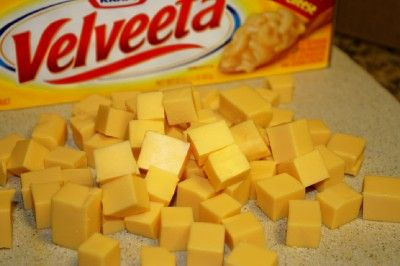

In [105]:
Image(filename='2.jpg', width = 450, height = 300) 

In [ ]:
with open('yelp_reviews_with_fake_1.txt','a') as f:
    for i in range (0, len(all_review)):
        f.write(str(all_review[i][0]) + ',' + str(all_review[i][1]) + ',' + str(all_review[i][2]) + ',' + str(all_review[i][3]) + ',' + '\n')

Type 1 Fake Review Result:


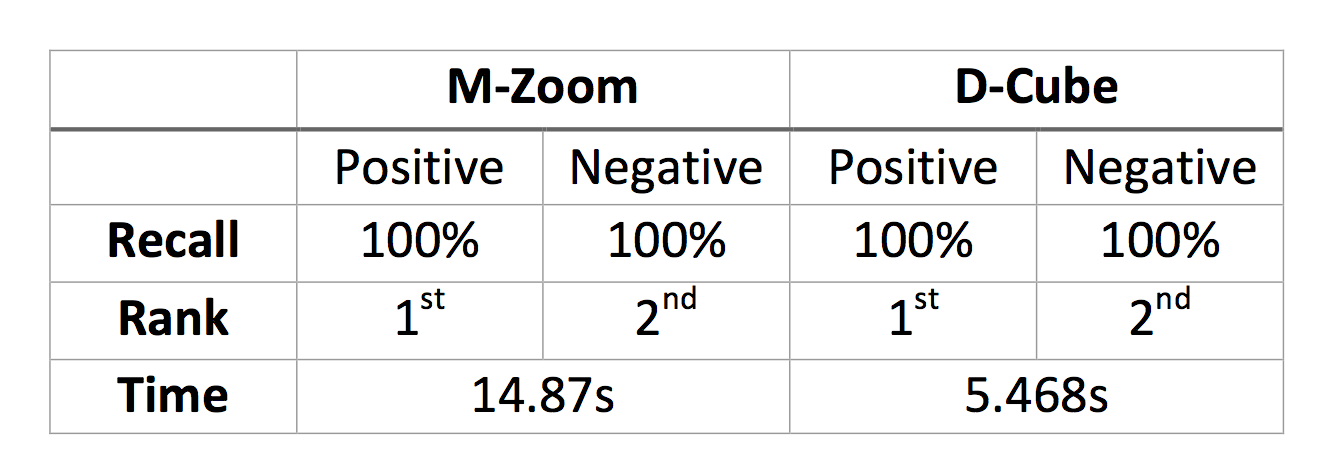

In [103]:
print "Type 1 Fake Review Result:"
Image(filename='01.png', width = 450, height = 300) 

#### Type 2: Employed Users (Real users are employed to review businesses)
Now, we are planning to add more challege on these two algorithms. In the Type 2 injective dataset, we are using real users, instead of generated fraud users, who will be employed to give fake (both positive and negative) reviews to some businesses. We will also do the shuffling processes after injecting them.

In [ ]:
fake_user_positive = np.arange(len(user_set))[np.random.permutation(len(user_set))[:50]]
fake_business_positive = np.arange(len(business_set))[np.random.permutation(len(business_set))[:50]]
fake_date_positive = np.arange(len(date_set))[np.random.permutation(len(date_set))[:20]]

fake_user_negative = np.arange(len(user_set))[np.random.permutation(len(user_set))[:50]]
fake_business_negative = np.arange(len(business_set))[np.random.permutation(len(business_set))[:50]]
fake_date_negative = np.arange(len(date_set))[np.random.permutation(len(date_set))[:20]]

print "Type 2 Positive Fake Reveiw Size: "
print str(len(fake_user_positive)) + " * " + str(len(fake_business_positive)) + " * " + str(len(fake_date_positive))

print "Type 2 Negative Fake Reveiw Size: "
print str(len(fake_user_negative)) + " * " + str(len(fake_business_negative)) + " * " + str(len(fake_date_negative))

fake_review = []
for i in range (0,len(fake_user_positive)):
    for j in range (0,len(fake_business_positive)):
        for k in range (0,len(fake_date_positive)):
            fake_review.append([fake_user_positive[i],fake_business_positive[j],fake_date_positive[k],5])

for i in range (0,len(fake_user_negative)):
    for j in range (0,len(fake_business_negative)):
        for k in range (0,len(fake_date_negative)):
            fake_review.append([fake_user_negative[i],fake_business_negative[j],fake_date_negative[k],1])

all_review = real_review + fake_review

with open('yelp_reviews_with_fake_2.txt','a') as f:
    for i in range (0, len(all_review)):
        f.write(str(all_review[i][0]) + ',' + str(all_review[i][1]) + ',' + str(all_review[i][2]) + ',' + str(all_review[i][3]) + ',' + '\n')

Type 2 Fake Review Result:


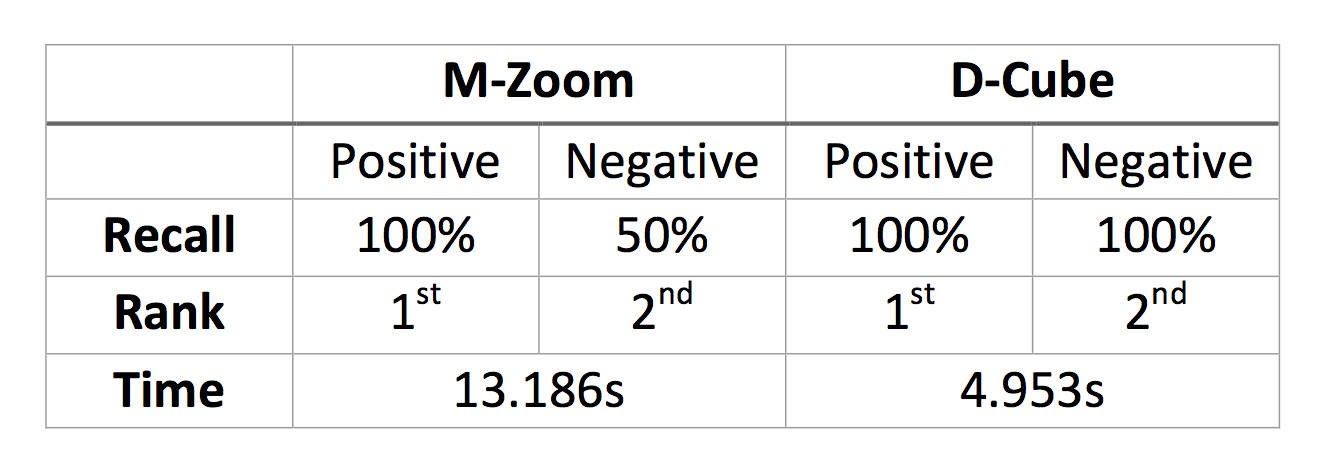

In [98]:
print "Type 2 Fake Review Result:"
Image(filename='02.png', width = 450, height = 300) 

#### Type 3: Employed Users (Real users are employed to review businesses)

Based on the Type 2 injective data, we make the Type 3 data which randomly deleting some (30%) fake injective reviews and make the injective block be more real. In the real world, suppose some of real users or reviews are detected and blocked by Yelp, the fake reviews block could not perfectly exist.

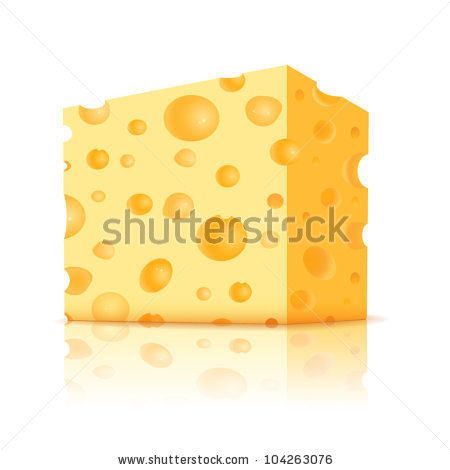

In [100]:
Image(filename='3.jpg', width = 450, height = 300) 

In [ ]:
fake_user_positive = np.arange(len(user_set))[np.random.permutation(len(user_set))[:200]]
fake_business_positive = np.arange(len(business_set))[np.random.permutation(len(business_set))[:10]]
fake_date_positive = np.arange(len(date_set))[np.random.permutation(len(date_set))[:10]]

fake_user_negative = np.arange(len(user_set))[np.random.permutation(len(user_set))[:200]]
fake_business_negative = np.arange(len(business_set))[np.random.permutation(len(business_set))[:10]]
fake_date_negative = np.arange(len(date_set))[np.random.permutation(len(date_set))[:10]]

print "Type 3 Positive Fake Reveiw Size: "
print str(len(fake_user_positive)) + " * " + str(len(fake_business_positive)) + " * " + str(len(fake_date_positive))

print "Type 3 Negative Fake Reveiw Size: "
print str(len(fake_user_negative)) + " * " + str(len(fake_business_negative)) + " * " + str(len(fake_date_negative))

fake_review = []
for i in range (0,len(fake_user_positive)):
    for j in range (0,len(fake_business_positive)):
        for k in range (0,len(fake_date_positive)):
            fake_review.append([fake_user_positive[i],fake_business_positive[j],fake_date_positive[k],5])

for i in range (0,len(fake_user_negative)):
    for j in range (0,len(fake_business_negative)):
        for k in range (0,len(fake_date_negative)):
            fake_review.append([fake_user_negative[i],fake_business_negative[j],fake_date_negative[k],1])

a = np.array(fake_review)
fake_review = list(a[np.random.permutation(a.shape[0])[:int(a.shape[0]*0.7)]])
            
all_review = real_review + fake_review

with open('yelp_reviews_with_fake_3.txt','a') as f:
    for i in range (0, len(all_review)):
        f.write(str(all_review[i][0]) + ',' + str(all_review[i][1]) + ',' + str(all_review[i][2]) + ',' + str(all_review[i][3]) + ',' + '\n')

Type 3 Fake Review Result:


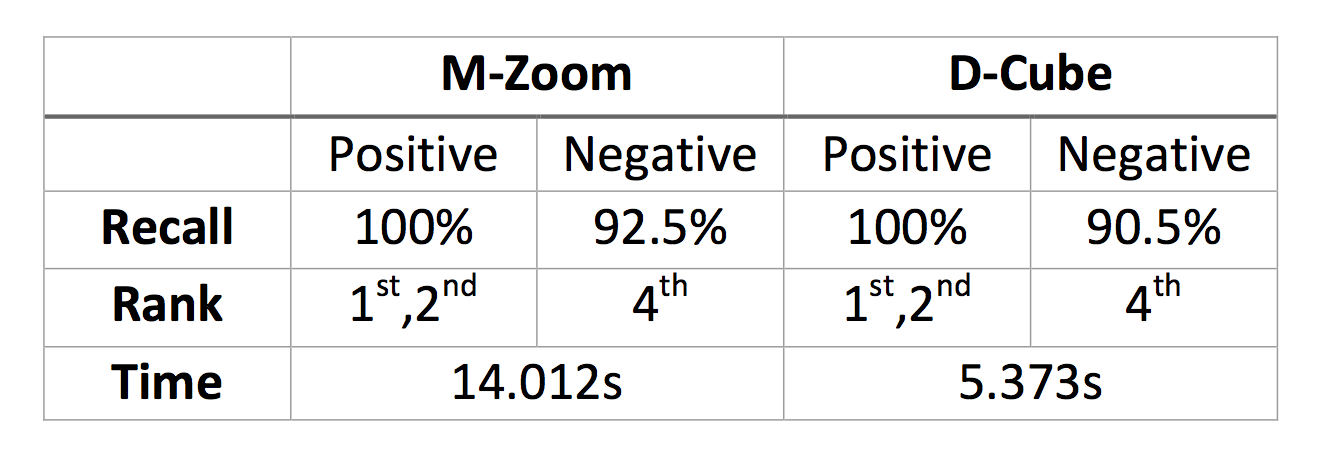

In [101]:
print "Type 3 Fake Review Result:"
Image(filename='03.png', width = 450, height = 300) 

#### Type 4: Smarter Employed Users (Real users are employed to give 4 or 5 for positive reviews, and 1 or 2 for negative reviews)
Rely on the Type 3 injective dateset, we plan to add more challenge here. In the real world, fraud users not only give 5 stars for positive reviews. but they also give 4 stars to make the fake reviews with more reality. Based on this case, we change our injective fake reviews with both 4 or 5 stars for positive reviews, and both 1 or 2 stars for negative reviews.

In [ ]:
fake_user_positive = np.arange(len(user_set))[np.random.permutation(len(user_set))[:50]]
fake_business_positive = np.arange(len(business_set))[np.random.permutation(len(business_set))[:50]]
fake_date_positive = np.arange(len(date_set))[np.random.permutation(len(date_set))[:20]]

fake_user_negative = np.arange(len(user_set))[np.random.permutation(len(user_set))[:50]]
fake_business_negative = np.arange(len(business_set))[np.random.permutation(len(business_set))[:50]]
fake_date_negative = np.arange(len(date_set))[np.random.permutation(len(date_set))[:20]]

print "Type 4 Positive Fake Reveiw Size: "
print str(len(fake_user_positive)) + " * " + str(len(fake_business_positive)) + " * " + str(len(fake_date_positive))

print "Type 4 Negative Fake Reveiw Size: "
print str(len(fake_user_negative)) + " * " + str(len(fake_business_negative)) + " * " + str(len(fake_date_negative))

fake_review = []
for i in range (0,len(fake_user_positive)):
    for j in range (0,len(fake_business_positive)):
        for k in range (0,len(fake_date_positive)):
            fake_review.append([fake_user_positive[i],fake_business_positive[j],fake_date_positive[k],np.random.permutation([4,5])[0]])

for i in range (0,len(fake_user_negative)):
    for j in range (0,len(fake_business_negative)):
        for k in range (0,len(fake_date_negative)):
            fake_review.append([fake_user_negative[i],fake_business_negative[j],fake_date_negative[k],np.random.permutation([1,2])[0]])

a = np.array(fake_review)
fake_review = list(a[np.random.permutation(a.shape[0])[:int(a.shape[0]*0.7)]])
            
all_review = real_review + fake_review

with open('yelp_reviews_with_fake_4.txt','a') as f:
    for i in range (0, len(all_review)):
        f.write(str(all_review[i][0]) + ',' + str(all_review[i][1]) + ',' + str(all_review[i][2]) + ',' + str(all_review[i][3]) + ',' + '\n')

Type 4 Fake Review Result:


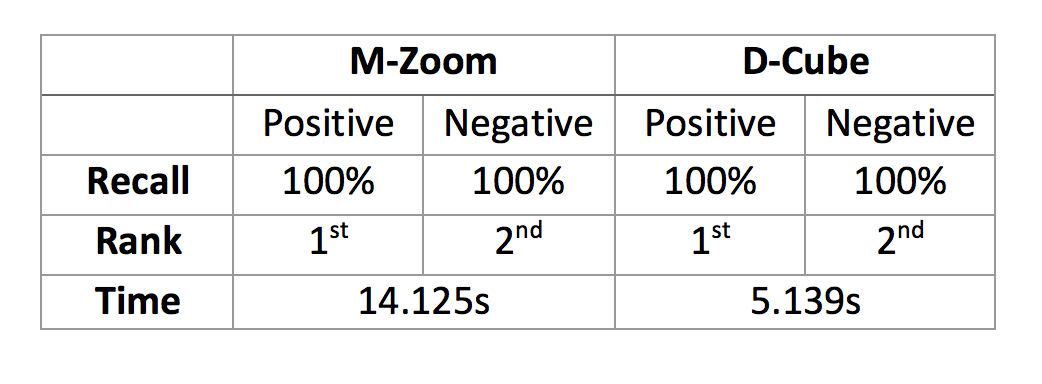

In [102]:
print "Type 4 Fake Review Result:"
Image(filename='04.png', width = 450, height = 300) 

### Conclusion
In total, based on the results we got above, we can make a conclusion that both D-Cube and M-Zoom work perfectly on detecting injective data. In terms of speed, D-Cube is much faster than traditional M-Zoom algorithm. 